---
# Part 0: Introduction Bayesian Inference


The main distinguishing characteristic of Bayesian inference is its ability to incorporate information that is not captured in observed data in a statistically valid way:

This concept is known as including a **prior** that is intended to reflect a belief about an outcome variable *before seeing any data*. This could come in the form of expert opinions, past research, gut feeling, business context, etc. Consequently, this prior is combined with the observational data

The prior values should be specified before commencing analysis. Then, as more empirical evidence is observed we combine the two information sources to produce and apply our inference on what is known as a **posterior**.

$$
Posterior = Prior \times \text{Observed evidence}
$$



In [51]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import random
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Control randomness for reproducibility
random.seed(1)

---
# Part 1: Data Generating Process


In this A/B test example, the VOI is ```conversion_rate```, a commonly relevant (binary) variable that we can simulate by sampling from a **Bernoulli distribution**. The treatment effect can be simulated by changing the mean of the control/treatment group.

User Input:
- ``n`` = Sample sizes
- ``true_prob`` = True conversion probability (with optional treatment effect)

Output:
- Two dictionaries: ```C``` (control), ```T``` (Treatment)
  - ``n`` = Sample size
  - ``true_prob`` = conversion rate of true DGP
  - ``sample`` = conversion outcomes
  - ``converted`` = total number of conversions = sum(sample)
  - ``sample_conversion_rate`` = conversion rate of sample

In [52]:
# Define Control & Treatment DGP (Bernoulli distributed)
C = {"n": 100, "true_prob": 0.5}
T = {"n": 100, "true_prob": 0.55}

In [53]:
def get_bernoulli_sample(mean, n):
    # Sample bernoulli distribution with relevant metrics
    samples = [1 if random.random() < mean else 0 for _ in range(n)]
    converted = sum(samples)
    mean = converted/n

    return samples, converted, mean

C["sample"], C["converted"], C["sample_conversion_rate"] = get_bernoulli_sample(mean = C["true_prob"], n = C["n"])
T["sample"], T["converted"], T["sample_conversion_rate"] = get_bernoulli_sample(mean = T["true_prob"], n = T["n"])

# visualise data structure
print(f"Control: {C['sample'][:10]}, Sample Conversion_Rate = {C['sample_conversion_rate']} (true = {C['true_prob']}) \nTreatment: {T['sample'][:10]}, Sample Conversion_Rate = {T['sample_conversion_rate']} (true = {T['true_prob']})")
print(f"\nsimulated treatment effect = {round((T['true_prob'] - C['true_prob'])*100, 2)}%")

Control: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1], Sample Conversion_Rate = 0.47 (true = 0.5) 
Treatment: [1, 0, 0, 1, 1, 1, 1, 1, 1, 0], Sample Conversion_Rate = 0.61 (true = 0.55)

simulated treatment effect = 5.0%


---
# Part 2: Prior


When considering priors in Bayesian A/B testing, to understand (and control) their effect, it is important to recognise where exactly they are present.

The following section elaborates on 2 types of priors:
- Prior odds (Hypothesis prior)
- Marginal likelihood prior (Parameter prior)

## Prior 1: Prior odds


**Definition: prior beliefs about probability of hypothesis being true.**

$$
Posterior = \mathbf{Prior} \times BF
$$


$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{\mathbf{P(H_1)}}{\mathbf{P(H_0)}} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$

User input:
- ```prior_odds``` = relative odds of alternative/null hypothesis being true. For example, a *prior_odds = 2* reflect 2:1 odds in favor of $H_1$ and thus claiming a prior belief of $H_1$ having twice as much likelihood of being true when compared to the $H_0$.


In [54]:
# Define Prior odds
prior_odds = 1

## Prior 2: Marginal likelihood prior


**Definition: prior beliefs about DGP parameter distributions, conditional on a hypothesis being true**

In Bayesian A/B testing, observational evidence is captured in so-called **Bayes Factors (BF)**.

$$
Posterior = Prior \times \mathbf{BF}
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{\mathbf{P(\text{Data}| H_1)}}{\mathbf{P(\text{Data}| H_0)}}
$$


A Bayes Factor is a ratio of **Marginal Likelihoods**, not to be mistaken for normal likelihoods. In short: a Likelihood quantifies how probable the observed data is for a specific parameter value, while marginal likelihood averages the data's probability over all plausible parameter values within a given model through integration.

$$
P(\text{Data}| H_0) = \int P(\text{Data}|\lambda, H_0) \mathbf{P(\lambda|H_0)} \, d\lambda
$$

In this context, the parameter $\lambda$ represents the conversion rate for the treatment/control group's (assumed) DGP, i.e. $data \sim Bernoulli(\lambda)$, over which we need to specify a prior as well. This affects how the averaging process in marginal likelihood is executed. In this context, the prior reflects the expected probability distribution of the conversion rate parameter for the bernoulli distribution behind the control/treatment data, thus a *prior belief on a DGP parameter distribution*.

The assumed distribution here is a **Beta-Binomial distribution**, a distribution that fits our purposes because:
- Only defined in range (0,1), just like our target variable ```conversion rate``` (probability)
- Marginal Likelihood computation convenience
- Beta-distributed priors are *conjugate*, meaning that they are guarenteed to preserve their beta distribution after being updated with data.

see: https://medium.com/@ro.mo.flo47/the-beta-binomial-model-an-introduction-to-bayesian-statistics-154395875f93

User input:
- ```mean``` = prior belief on conversion rate
- ```weight``` = prior distribution variance, or practically speaking, the degree of certainty in prior belief (recommended to play around with multiple values while inspecting the prior visualisations).

In [55]:
# Specify prior distribution (mean + "weight" as proxy for variance)
mean_C, weight_C = 0.5, 1000
mean_T, weight_T = 0.55, 1000

Helper function to abstract away, the transformation steps to get from tangible prior beliefs on effect magnitude (mean) & associated certainty (weight) to Beta distributions parameters.

Output:
- Two dictionaries ```C_prior``` (Control), ```T_prior``` (Treatment):
  - ```alpha``` = shape & location parameter, skews distribution to higher conversion rates ($\lambda$ = 1)
  - ```beta``` = shape & location parameter, skews distribution to lower conversion rates ($\lambda$ = 0)

In [56]:
# Help function with determining alpha & beta
def beta_helper(prior_prob, weight):
    # Sample from Beta distribution: B(weight(prior belief) + 1, weight(1 - prior belief) + 1)
    a = round(prior_prob, 2) * weight + 1
    b = (1 - round(prior_prob, 2)) * weight + 1
    return round(a), round(b)

# parameters: Mean, weight
C_prior, T_prior = dict(), dict()
C_prior["alpha"], C_prior["beta"] = beta_helper(mean_C, weight_C)
T_prior["alpha"], T_prior["beta"] = beta_helper(mean_T, weight_T)

Plot priors:

using helper function:


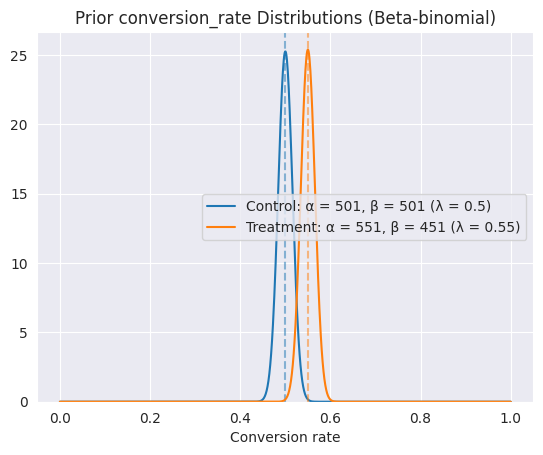

In [57]:
# Visualisation function for beta distribution
def plot_beta_distribution(T_alpha, T_beta, T_mean, C_alpha, C_beta, C_mean):
    x = np.linspace(0, 1, 1000)

    # Calculate the value of the pdf for each x value
    C_dist = stats.beta.pdf(x, C_alpha, C_beta)
    T_dist = stats.beta.pdf(x, T_alpha, T_beta)

    # Plot distributions & means
    plt.plot(x, C_dist, label=f'Control: α = {C_alpha}, β = {C_beta} (λ = {C_mean})', color = _colors[0])
    plt.axvline(C_mean, color = _colors[0], linestyle = "--", alpha = 0.5)

    plt.plot(x, T_dist, label=f'Treatment: α = {T_alpha}, β = {T_beta} (λ = {T_mean})', color = _colors[1])
    plt.axvline(T_mean, color = _colors[1], linestyle = "--", alpha = 0.5)

    plt.title('Prior conversion_rate Distributions (Beta-binomial)')
    plt.xlabel('Conversion rate')
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()

print("using helper function:")
plot_beta_distribution(T_prior["alpha"], T_prior["beta"], mean_T, C_prior["alpha"], C_prior["beta"], mean_C)

---
# Part 3: Bayes Factor

The Bayes Factor (BF), defined as a ratio of Marginal Likelihoods (not to be mistaken for a regular likelihood ratio) and can be interpreted as the data-driven component of Bayesian Infernece as all observational information should be captured in this term.

$$
Posterior = Prior \times \mathbf{BF}
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{\mathbf{P(\text{Data}| H_1)}}{\mathbf{P(\text{Data}| H_0)}}
$$

The Bayes factor reflect relative odds of alternative/null hypothesis being true, purely based on the data observed. For example, a *BF = 2* reflect 2:1 odds in favor of $H_1$ and thus claiming a prior belief of $H_1$ having twice as much likelihood of being true when compared to the $H_0$. An important property in Bayesian A/B testing is that this interpretation is preserved, even under early stopping of experiments (https://arxiv.org/abs/1602.05549).

## Derivation Bayes Factor


Given a (conjugate) Beta-binomial parameter prior, we can obtain our marginal likelihoods as follows:

$$ P[data|H] = \frac{Beta(\alpha + c, \beta + (n-c) )}{\beta(\alpha, \beta)} = \frac{(
  \frac{\Gamma(\alpha + c)\Gamma(\beta + (n-c))}{\Gamma(\alpha + \beta + n)})
}{(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)})}$$
where:
- $\alpha$, $\beta$ = Beta-prior parameters,
- *c* = total number of conversions
- *n* = sample size.
- $\Gamma(\theta)$ = Gamma function = $\int_0^\infty x^{\theta-1} e^{-x} \, dx$

The main question becomes which parameters to plug in this function, as multiple combinations of values can be justified. To capture the following Hypotheses

$$ \mathbf{H_0}: \lambda_{control} = \lambda_{treatment} \qquad\quad \mathbf{H_1}: \lambda_{control} \neq \lambda_{treatment} $$

we can employ the following design:

### H0: The Null Hypothesis - Same Distribution

- **Marginal Likelihood**:
  $$P[data_{t} + data_{c}|H_0] = \frac{Beta(\alpha_0 + c_t + c_c, \beta_0 + (n_t + n_c - c_t - c_c))}{\beta(\alpha_0, \beta_0)} $$

- **Intuition**:
  We're treating the treatment and control groups as if they're one big group. We're asking, "Given our prior beliefs and the observed data, what's the likelihood that both groups follow the same conversion distribution?"

- **Data Scientist Context**:
  Think of it like pooling the results of two A/B test variants and evaluating how probable the combined data is, under the assumption that there's no difference between them.



### H1: The Alternative Hypothesis - Different Distributions

- **Marginal Likelihood**:
  $$P[data_{t}, data_{c}|H_1] = \frac{Beta(\alpha_t + c_t, \beta_t + (n_t - c_t))}{\beta(\alpha_t, \beta_t)} \times \frac{Beta(\alpha_c + c_c, \beta_c + (n_c - c_c))}{\beta(\alpha_c, \beta_c)} $$

- **Intuition**:
  Here, we're separating the treatment and control groups, evaluating each on its own. It's like asking, "How likely is the data if the treatment and control groups follow different conversion distributions?"

- **Data Scientist Context**:
  It's akin to evaluating two A/B test variants individually. You're trying to determine if each variant's data is more probable under the assumption that they come from distinct underlying distributions.
- Note that for these hypotheses, $\alpha_0$, $\beta_0$ are equal to $\alpha_c$, $\beta_c$ by construction, when assuming no treatment effect on the control group.

### Bayes Factor

Using the results above, the Bayes Factor becomes:

$$BF_{H_1|H_0} = \frac{
  P[data_{t}, data_{c}|H_1]}{P[data_{t} + data_{c}|H_0]}
= \frac{(
  \frac{Beta(\alpha_t + c_t, \beta_t + (n_t - c_t))}{\beta(\alpha_t, \beta_t)} \times \frac{Beta(\alpha_c + c_c, \beta_c + (n_c - c_c))}{\beta(\alpha_c, \beta_c)}
)}{
  \frac{Beta(\alpha_0 + c_t + c_c, \beta_0 + (n_t + n_c - c_t - c_c))}{\beta(\alpha_0, \beta_0)}
} $$


## Python implementation

This implementation uses ```scipy.special.betaln```, a beta function that uses logarithms to bypass computational issues we would face otherwise when scaling sample sizes up.

In [58]:
from scipy.special import betaln

def beta_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c):
    # Log probability of data under H0
    log_prob_data_H0 = betaln(alpha_0 + c_t + c_c, beta_0 + n_t + n_c - c_t - c_c) - betaln(alpha_0, beta_0)

    # Log probability of data under H1 for treatment group
    log_prob_data_H1_treatment = betaln(alpha_t + c_t, beta_t + n_t - c_t) - betaln(alpha_t, beta_t)

    # Log probability of data under H1 for control group
    log_prob_data_H1_control = betaln(alpha_c + c_c, beta_c + n_c - c_c) - betaln(alpha_c, beta_c)

    # Log joint probability of data under H1
    log_prob_data_H1 = log_prob_data_H1_treatment + log_prob_data_H1_control

    # Compute Log Bayes Factor and convert to regular Bayes Factor
    log_BF_10 = log_prob_data_H1 - log_prob_data_H0
    bf_10 = np.exp(log_BF_10)

    return bf_10

# Collect the correct parameters:
alpha_0, beta_0 = C_prior["alpha"], C_prior["beta"]
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"]
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"]
c_t, n_t = T["converted"], T["n"]  # Successes and total observations for treatment group
c_c, n_c = C["converted"], C["n"]  # Successes and total observations for control group

beta_bayes_factor = beta_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, c_t, n_t, c_c, n_c)
print(f"Bayes Factor (BF_10) = {beta_bayes_factor}")

Bayes Factor (BF_10) = 5.341429662841594


---
# Part 4: Posterior & Inference


$$
\mathbf{Posterior} = Prior \times BF
$$

$$
\frac{\mathbf{P(H_1| \text{Data})}}{\mathbf{P(H_0| \text{Data})}} = \frac{P(H_1)}{P(H_0)} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$


In [59]:
# Calculate post odds & convert to %
post_odds = prior_odds * beta_bayes_factor
prob_effect = round(post_odds / (post_odds + 1) * 100, 2)

print(f"Posterior probability of Signficant Treatment effect: {prob_effect}%")

Posterior probability of Signficant Treatment effect: 84.23%
